<a href="http://scikit-learn.org/dev/modules/generated/sklearn.neighbors.LocalOutlierFactor.html">scikit api spec</a>

In [1]:
import sys
import notebookutil as nbu
sys.meta_path.append(nbu.NotebookFinder())
import datasets
import roc_auc
import numpy as np
from sklearn.neighbors import LocalOutlierFactor
from sklearn.base import BaseEstimator
from sklearn.metrics.pairwise import paired_distances

In [2]:
class EstimatorLOF(BaseEstimator):
    def __init__(self, n_neighbors=20, algorithm='ball_tree', metric='minkowski'):
        self.param = {}
        self.param['n_neighbors'] = n_neighbors
        self.param['algorithm'] = algorithm
        self.param['metric'] = metric
        self.estimator = LocalOutlierFactor(n_neighbors, algorithm=algorithm, metric=metric)
        
    def fit(self, x):
        self.train_data = x
        return self 

    def predict(self, x):
        return [1.0]*len(x) 
    
    def decision_function(self, x, y=None):
        X = self.train_data
        X.append(np.nan)  # allocate the index for test
        test_idx = len(X) - 1
        
        lof_score = []
        for _x in x:
            X[test_idx] = _x
            self.estimator.fit(X)
            lof_score.append(-self.estimator._decision_function(X)[test_idx])
        
        X.pop() # deallocate the index for test
        return lof_score
    
    def score(self, x, y=None):
        scores = self.decision_function(x)
        return sum(scores)/len(scores)

    def get_params(self, deep=True):
        return self.param

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self,parameter, value)
        return self
    
    def get_type(self):
        return 'LOF'

In [5]:
def small_test():
    lof = EstimatorLOF(n_neighbors=2)
    lof.fit([[1,1],[2,1],[3,1]])
    print(lof.decision_function([[4,0], [5,0]]))
    return lof
    
#small_test()

[1.0639995150329815, 1.3997242729180468]


EstimatorLOF(algorithm='ball_tree', metric='minkowski', n_neighbors=2)

In [6]:
#ds = datasets.load('data/raw/01_0[12]_01*')

path = data/raw/01_0[12]_01*
data/raw/01_01_01_4F実験室_XperiaZ3_胸ポケット_裏上_正常_まっすぐ帰宅
..............................
data/raw/01_02_01_4F実験室_XperiaZ3_胸ポケット_裏上_異常_まっすぐ外出
..............................


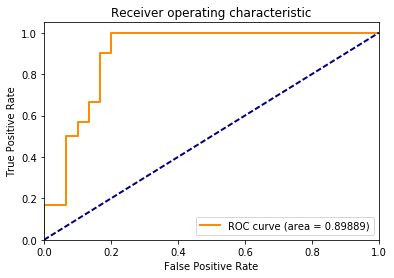

auc 0.89889


In [10]:
import importlib
#importlib.reload(roc_auc)
import roc_auc
import datasets

def test():
    sensor_type = ['rssi.a','rssi.b', ['linear_accel[0]','linear_accel[1]','linear_accel[2]']]
    n_record = 10
    drop_interval = 2
    ma_window = 2
    normalize = True
    
    # get data
    dfl_b = datasets.get_data(ds, title='01_01_01', before=n_record,
                              column=sensor_type, drop_interval=drop_interval)[:3]
    dfl_n = datasets.get_data(ds, title='01_01_01', before=n_record,
                              column=sensor_type, drop_interval=drop_interval)
    dfl_o = datasets.get_data(ds, title='01_02_01', before=n_record,
                              column=sensor_type, drop_interval=drop_interval)

    # moving average
    dfl_b = datasets.moving_average(dfl_b, window=ma_window, min_periods=ma_window)
    dfl_n = datasets.moving_average(dfl_n, window=ma_window, min_periods=ma_window)
    dfl_o = datasets.moving_average(dfl_o, window=ma_window, min_periods=ma_window)
    
    # normalize
    if normalize == True:
        dfl_b_n = datasets.normalize_by_base_data(dfl_b, dfl_b, sensor_type)
        dfl_n_n = datasets.normalize_by_base_data(dfl_b, dfl_n, sensor_type)
        dfl_o_n = datasets.normalize_by_base_data(dfl_b, dfl_o, sensor_type)

    # get numpy array
    data_2d_b = [df.as_matrix() for df in dfl_b_n]
    data_2d_n = [df.as_matrix() for df in dfl_n_n]
    data_2d_o = [df.as_matrix() for df in dfl_o_n]

    # to list of numpy.array
    data_b = [d.ravel() for d in data_2d_b]
    data_n = [d.ravel() for d in data_2d_n]
    data_o = [d.ravel() for d in data_2d_o]

    model = EstimatorLOF(n_neighbors=3)
    model.fit(data_b)
    score_n = model.decision_function(data_n)
    score_o = model.decision_function(data_o)
    
    auc = roc_auc.get_auc_from_normal_outlier(score_n, score_o, graph=True)

    print('auc %.05f' % (auc))
    
#test()